# 第三章 线性神经网络

## 3.1 线性回归

### 3.1.1 线性回归的基本元素

#### 线性模型
* 单样本 $\hat{y} = w_1x_1 + ... + w_dx_d + b$

* 单样本向量表示 $\hat{y} = {\textbf{w}}^T\textbf{x} + b$

* 多样本 $\hat{\textbf{y}} = \textbf{X}\textbf{w} + b$

#### 损失函数
量化目标的实际值与预测值之间的差距
* 单样本 $l^{(i)}(\textbf{w}, b) = \frac{1}{2}({\hat{y}}^{(i)}-y^{(i)})^2$

* 多样本 $L(\textbf{w},b) = \frac{1}{n}\sum\limits_{i=1}^{n}l^{(i)}(\textbf{w}, b) = \frac{1}{n}\sum\limits_{i=1}^{n}\frac{1}{2}({\textbf{w}}^T{\textbf{x}}^{(i)}+b-y^{(i)})^2$

训练模型的目标：寻找一组参数$(\textbf{w}^*,b^*)$，这组参数能**最小化在所有训练样本上的总损失**，即：

$$\textbf{w}^*,b^* = \underset{\textbf{w},b}{argmin} L(\textbf{w},b)$$

#### 解析解
线性回归存在解析解：
1. 将偏置$b$合并到参数$\textbf{w}$中，即在包含所有参数的矩阵中附加一列
2. 预测问题变为最小化${||\textbf{y}-\textbf{Xw}||}^2$
3. 损失关于$\textbf{w}$导数为0处为解析解：${\textbf{w}}^*=({\textbf{X}}^T\textbf{X})^{-1}{\textbf{X}}^T{\textbf{y}}$

#### 随机梯度下降
并不是所有问题都存在解析解，所以需要随机梯度下降

* 梯度下降 (gradient descent)
    * 不断在损失函数递减的方向上（关于模型参数的导数）更新参数来降低误差
    * 性能问题：每一次更新参数之前都需要遍历整个数据集
* 随机梯度下降 (minibatch stochastic gradient descent)
    * 在每次需要计算更新的时候抽取一小批样本
    * 更新过程的数学表示：
      $$(\textbf{w},b)\leftarrow(\textbf{w},b)-\frac{\eta}{|B|}\sum\limits_{i\in{B}}\partial_{(\textbf{w},b)}l^{(i)}(\textbf{w}, b)$$
        * $\eta$: 学习率
        * $|B|$: 每个小批量中的样本数，即批量大小
        * $\eta$和$|B|$需手动指定，称为**超参数（hyperparameter）**，**调参**是选择超参数的过程
    * 展开：
      $$\textbf{w}\leftarrow\textbf{w}-\frac{\eta}{|B|}\sum\limits_{i\in{B}}\partial_{\textbf{w}}l^{(i)}(\textbf{w}, b)=\textbf{w}-\frac{\eta}{|B|}\sum\limits_{i\in{B}}{\textbf{x}}^{(i)}({\textbf{w}}^T{\textbf{x}}^{(i)}+b-y^{(i)})$$

      $$b\leftarrow b-\frac{\eta}{|B|}\sum\limits_{i\in{B}}\partial_bl^{(i)}(\textbf{w}, b)=b-\frac{\eta}{|B|}\sum\limits_{i\in{B}}({\textbf{w}}^T{\textbf{x}}^{(i)}+b-y^{(i)})$$

### 3.1.2 矢量化加速
对计算进行矢量化从而利用**线性代数库**，而不是使用Python for循环

示例：

In [4]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

class Timer: #@save
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平时时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

n = 10000
a = torch.ones([n])
b = torch.ones([n])
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.22326 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

### 3.1.3 正态分布与平方损失

#### 正态分布 normal distribution
* 也称为高斯分布（Gaussian distribution）
* 随机变量$x$具有均值$\mu$和方差${\sigma}^2$，其正态分布概率密度函数如下：
$$p(x)=\frac{1}{\sqrt{2\pi{\sigma}^2}}\text{exp}(-\frac{1}{2{\sigma}^2}(x-\mu)^2)$$

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

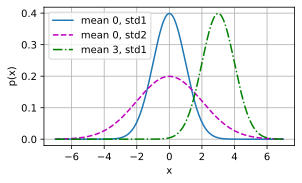

In [7]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5), legend=[f'mean {mu}, std{sigma}' for mu, sigma in params])

#### 为什么均方误差损失函数（均方损失）可以用于线性回归
* 假设观测中包含噪声，噪声服从正态分布，如下：
  $$y=\textbf{w}^\text{T}\textbf{x}+b+\epsilon$$
  其中$\epsilon \sim \mathcal{N}(0,\sigma^2)$
* 通过给定$\textbf{x}$观测到特定$y$的似然（likelihood）
  $$P(y|\textbf{x})=\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{1}{2\sigma^2}(y-\textbf{w}^\text{T}\textbf{x}-b)^2)$$
* 根据极大似然估计法，参数$\textbf{w}$和$b$的最优值是使整个数据集的似然最大的值
  $$P(\textbf{y}|\textbf{X})=\prod_{i=1}^np(y^{(i)}|\textbf{x}^{(i)})$$
* 改为最小化负对数似然
  $$-logP(\textbf{y}|\textbf{X})=\sum_{i=1}^n(\frac{1}{2}\text{log}(2\pi\sigma^2)+\frac{1}{2\sigma^2}(y^{(i)}-\textbf{w}^{\text{T}}\textbf{x}^{(i)}-b)^2)$$
* 第一项不依赖$\textbf{w}$和$b$，第二项除了常数$\frac{1}{\sigma^2}$外，其余部分和均方差是一样的。因此在高斯噪声的假设下，最小化均方差等价于对线性模型的极大似然估计

### *极大似然估计（maximum likelihood estimation, MLE）*
* 利用已知样本结果信息，反推最有可能导致这些样本结果出现的模型参数值
* 既然事情发生了，就让这个出现的结果的可能性最大

### 3.1.4 从线性回归到深度网络
#### 神经网络图
![图3.1.2](./images/3.1.2.png)
* 线性回归是一个单层神经网络（不考虑输入层）
* 对于线性回归，每个输入都与每个输出相连，这种变换称为 **全连接层（fully-connected layer）** 或稠密层（dense layer）

## 3.2 线性回归的从零开始实现

In [8]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集

In [11]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [12]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features: ', features[0], '\nlabel: ', labels[0])

features:  tensor([ 0.4281, -0.7088]) 
label:  tensor([7.4569])


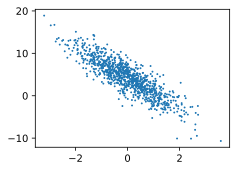

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2 读取数据集

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6296, -0.3314],
        [-0.2891, -1.2773],
        [ 0.3184,  1.4696],
        [ 0.3817,  0.5549],
        [-0.6520, -0.3300],
        [ 0.4539, -0.2939],
        [ 1.4540, -0.1738],
        [-0.1702, -1.3687],
        [ 0.3691, -0.1569],
        [ 0.9621, -1.4380]]) 
 tensor([[ 6.5786],
        [ 7.9695],
        [-0.1730],
        [ 3.0739],
        [ 4.0068],
        [ 6.1196],
        [ 7.6895],
        [ 8.5113],
        [ 5.4822],
        [11.0229]])


### 3.2.3 初始化模型参数

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型

In [23]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 3.2.5 定义损失函数

In [19]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法

In [20]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 训练

In [25]:
lr = 0.03 # 学习率
num_epochs = 3
net = linreg
loss = squared_loss

In [26]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l的形状是(batch_size, 1)，而不是一个标量。l中所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.027894
epoch 2, loss 0.000105
epoch 3, loss 0.000053


In [28]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-9.5129e-05, -4.0722e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0006], grad_fn=<RsubBackward1>)


# 3.3 线性回归的简洁实现
使用深度学习框架

### 3.3.1 生成数据集

In [31]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [32]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 读取数据集
参数is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据

In [34]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [35]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [36]:
next(iter(data_iter))

[tensor([[ 0.7982, -0.5338],
         [-0.5346,  0.2713],
         [ 0.5721,  0.8204],
         [ 2.8432, -0.0747],
         [ 0.3599, -1.2940],
         [ 1.7000,  0.2964],
         [ 1.3108,  0.8199],
         [ 0.3495, -0.2788],
         [ 2.1038,  2.1748],
         [ 0.1557,  0.6313]]),
 tensor([[ 7.5994],
         [ 2.2188],
         [ 2.5674],
         [10.1379],
         [ 9.3180],
         [ 6.5994],
         [ 4.0367],
         [ 5.8415],
         [ 1.0151],
         [ 2.3635]])]

### 3.3.3 定义模型
* 在PyTorch中，全连接层在Linear类中定义
* nn.Linear()的参数
  * 输入特征形状
  * 输出特征形状

In [37]:
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

### 3.3.4 初始化模型参数

In [38]:
# net[0]选择网络中的第一个图层
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 3.3.5 定义损失函数
* 计算均方误差使用MSELoss类，也称为平方$L_2$范数。默认返回所有样本损失的平均值

In [39]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法
* PyTorch在optim模块中实现了小批量随机梯度下降算法的许多变种

In [40]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练

In [41]:
num_epoch = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000227
epoch 2, loss 0.000092
epoch 3, loss 0.000092


In [42]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0003,  0.0002])
b的估计误差： tensor([-3.8147e-05])


# 3.4 softmax回归

## 3.4.1 分类问题
* 问题
    * 图像分类问题。假设每次输入是一个2x2的灰度图像。用一个标量表示每个像素值，每个图像对应四个特征$x_1, x_2, x_3, x_4$。假设每个图像属于类别”猫“，”鸡“和”狗“中的一个
* 如果类别间有一些自然顺序，如{婴儿，儿童，青少年，青年人，中年人，老年人}，那么可以将分类问题转变为回归问题
* 否则，可以使用 **独热编码（one-hot encoding）** 表示分类数据。独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0
* 对于猫鸡狗问题
  $$y\in\{(1,0,0),(0,1,0),(0,0,1)\}$$

### 3.4.2 网络架构
* 为了估计所有可能类别的概率，我们需要一个有多个输出的模型，**每个类别对应一个输出**
* 为了解决线性模型的分类问题，我们需要和输出一样多的**仿射函数（affine function）**
* 每个输出对应它自己的仿射函数
* 计算式：
  $$o_1=x_1w_{11}+x_2w_{12}+x_3w_{13}+x_4w_{14}+b_1,$$
  $$o_2=x_1w_{21}+x_2w_{22}+x_3w_{23}+x_4w_{24}+b_2,$$
  $$o_3=x_1w_{31}+x_2w_{32}+x_3w_{33}+x_4w_{34}+b_3.$$
  即$\textbf{o}=\textbf{W}\textbf{x}+\textbf{b}$
* 神经网络图：
  
  ![](./images/3.4.1.png)
  
  **softmax回归是一种单层神经网络**

### 3.4.3 全连接层的参数开销
* 理论上$d$个输入和$q$个输出的全连接层，参数开销是$\mathcal{O}(dq)$
* 但是，将$d$个输入转换为$q$个输出的成本可以减少到$\mathcal{O}(\frac{dq}{n})$，其中$n$是超参数，可以灵活指定

### 3.4.4 softmax运算
* 我们希望模型的输出$\hat{y}_j$可以视为属于类$j$的概率，然后选择具有最大输出值的类别$\text{argmax}_jy_j$作为我们的预测
* 输出值$o$不能直接使用，需要**规范化**
  * 没有限制输出数字的总和为1
  * 根据输入不同，输出可能为负值
* 规范化 - 解决上述2个问题
  $$\hat{\textbf{y}}=\text{softmax}(\textbf{o})$$
  其中\
  $$\hat{y_j}=\frac{\text{exp}(o_j)}{\sum_k{\text{exp}(o_k)}}$$
* softmax的性质
  * 不会改变未规范化的预测$\textbf{o}$之间的大小次序，即
  $$\underset{j}{\text{argmax}}\hat{y}_j=\underset{j}{\text{argmax}}o_j$$
  * softmax是一个非线性函数，但输出仍然由输入特征的仿射变换决定。因此，softmax回归是一个**线性模型（linear model）**

### 3.4.5 小批量样本的矢量化
* 读取批量样本$\textbf{X}$，其中特征维度（输入数量）为$d$，批量大小为$n$，输出有$q$个类别
* 那么，$\textbf{X}\in{\mathbb{R}^{n \times d}}$，权重$\textbf{W}\in{\mathbb{R}^{d \times q}}$，偏置$\textbf{b}\in{\mathbb{R}^{1 \times q}}$
* softmax回归的矢量计算表达式为
  $$\textbf{O}=\textbf{XW}+\textbf{b},$$
  $$\hat{\textbf{Y}}=\text{softmax}(\textbf{O}).$$

### 3.4.6 损失函数

#### 对数似然
$$P(\textbf{Y}|\textbf{X})=\prod_{i=1}^nP(\textbf{y}^{(i)}|\textbf{x}^{(i)})$$
根据最大似然估计，最大化$P(\textbf{Y}|\textbf{X})$，相当于最小化负对数似然：
$$-\text{log}P(\textbf{Y}|\textbf{X})=\sum_{i=1}^n-\text{log}P(\textbf{y}^{(i)}|\textbf{x}^{(i)})=\sum_{i=1}^nl(\textbf{y}^{(i)},\hat{\textbf{y}}^{(i)})$$
其中，对于任何标签$\textbf{y}$和模型预测$\hat{\textbf{y}}$，损失函数为：
$$l(\textbf{y},\hat{\textbf{y}})=-\sum_{j=1}^qy_i\text{log}\hat{y}_j$$
上述损失函数通常被称为 **交叉熵损失（cross-entropy loss）**，由于$\textbf{y}$是一个长度为$q$的独热编码向量，所以除了一个项以外的所有项$j$都消失了

#### softmax及其导数
$$l(\textbf{y},\hat{\textbf{y}})=-\sum_{j=1}^qy_i\text{log}\frac{\text{exp}(o_j)}{\sum_{k=1}^q{\text{exp}(o_k)}}=\sum_{j=1}^qy_j\text{log}\sum_{k=1}^q\text{exp}(o_k)-\sum_{j=1}^qy_jo_j=\text{log}\sum_{k=1}^q\text{exp}(o_k)-\sum_{j=1}^qy_jo_j$$
考虑相对于任何未规范化的预测$o_j$的导数，得到：
$$\partial_{o_j}l(\textbf{y},\hat{\textbf{y}})=\frac{\text{exp}(o_j)}{\sum_{k=1}^q{\text{exp}(o_k)}}-y_j=\text{softmax}(\textbf{o})_j-y_j$$
导数是softmax模型分配的概率与实际发生的情况（由独热标签向量表示）之间的差异

### 3.4.7 信息论基础

### 3.4.8 模型预测和评估
* 通常使用预测概率最高的类别作为输出类别。如果预测与实际类别（标签）一致，则预测是正确的
* 使用精度（accuracy）来评估模型的性能，精度等于正确预测数与预测总数的比率